# Import

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os

# Dataset

In [ ]:
cifar = tf.keras.datasets.cifar10
(x_train,y_train),(x_test,y_test) = cifar.load_data()
x_train,x_test = x_train/255.0 *2 - 1, x_test/255.0 *2 - 1
N, H, W, C  = x_train.shape

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
N, H, W, C

(50000, 32, 32, 3)

In [ ]:
latent_dim = 100

# Model

## Generator

In [ ]:

# Generator 
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256*4*4,activation=LeakyReLU(alpha=0.2))(i)
    x = Reshape((4,4,256))(x)
    x = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same',activation=LeakyReLU(alpha=0.2))(x)
    x = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same',activation=LeakyReLU(alpha=0.2))(x)
    x = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same',activation=LeakyReLU(alpha=0.2))(x)
    x = Conv2D(3,(3,3),padding='same',activation='tanh')(x)
    model = Model(i,x)
    return model
generator = build_generator(latent_dim)
generator.summary()    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 128)      262272

## Discriminator

In [ ]:
# Discriminator
def build_discriminator(in_shape=(32,32,3)):
    i = Input(shape=(in_shape))
    x = Conv2D(64,(3,3), padding='same', activation=LeakyReLU(alpha=0.2))(i)
    x = Conv2D(128,(3,3),strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = Conv2D(128,(3,3),strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = Conv2D(256,(3,3),strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1,activation='sigmoid')(x)
    model = Model(i,x)
    return model

discriminator = build_discriminator()
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dropout (Dropout)           (None, 4096)              0   

## Combined Model

In [ ]:
# Combined model
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)
combined_model = Model(z,fake_pred)
combined_model.compile(loss='binary_crossentropy',
                       optimizer=Adam(0.0002,0.5))
combined_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 model (Functional)          (None, 32, 32, 3)         1466115   
                                                                 
 model_1 (Functional)        (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


# Training

In [ ]:
batch_size = 32
epochs =5000
sample_period = 200

#batch label
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

#store loss
d_losses = []
g_losses = []

#create folder to store generated image
if not os.path.exists('gan_images'):
   os.makedirs('gan_images')

In [ ]:
def sample_images(epoch):
    rows,cols = 5,5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)
    imgs = 0.5 * imgs + 0.5
    fig, axs = plt.subplots(rows, cols,figsize=(5,5))
    idx = 0
    for i in range(rows):
      for j in range(cols):
        axs[i,j].imshow(imgs[idx])
        axs[i,j].axis('off')
        idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

In [ ]:
# Main training loop
for epoch in range(epochs):
    #Train Discriminator
    
    ## real images
    idx = np.random.randint(0,x_train.shape[0], batch_size)
    real_imgs = x_train[idx] 
    ## fake images
    noise = np.random.rand(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
    ## loss and accracy after training
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs,ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs,zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_fake + d_acc_real)

    #Train Generator
    
    ## Trick
    noise = np.random.randn(batch_size,latent_dim)
    g_loss = combined_model.train_on_batch(noise,ones)
    
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 100 == 0:
      print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f},\
          d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

    if epoch % sample_period == 0:
       sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 236ms/step
epoch: 101/5000, d_loss: 0.16,          d_acc: 0.97, g_loss: 2.70
1/1 [==============================] - 0s 250ms/step
epoch: 201/5000, d_loss: 0.00,          d_acc: 1.00, g_loss: 7.56
1/1 [==============================] - 0s 387ms/step
epoch: 301/5000, d_loss: 0.09,          d_acc: 0.95, g_loss: 15.50
1/1 [==============================] - 0s 232ms/step
epoch: 401/5000, d_loss: 0.00,          d_acc: 1.00, g_loss: 7.40
1/1 [==============================] - 0s 272ms/step
epoch: 501/5000, d_loss: 0.01,          d_acc: 1.00, g_loss: 6.68
1/1 [==============================] - 0s 245ms/step
epoch: 601/5000, d_loss: 0.08,          d_acc: 0.97, g_loss: 4.32
1/1 [==============================] - 0s 236ms/step
epoch: 701/5000, d_loss: 0.11,          d_acc: 0.94, g_loss: 0.63
1/1 [==============================] - 0s 228ms/step
epoch: 801/5000, d_loss: 0.15,          d_acc: 0.95, g_loss: 1

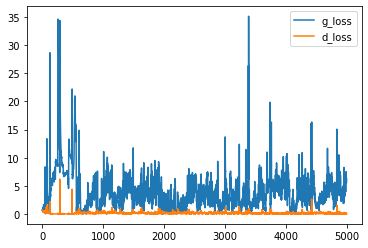

In [ ]:
plt.plot(g_losses, label='g_loss')
plt.plot(d_losses, label='d_loss')
plt.legend()

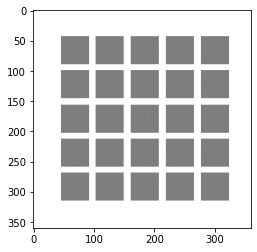

In [ ]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

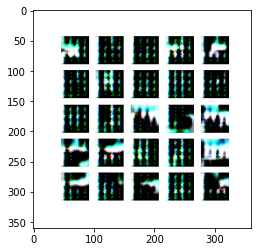

In [ ]:
from skimage.io import imread
a = imread('gan_images/1000.png')
plt.imshow(a)

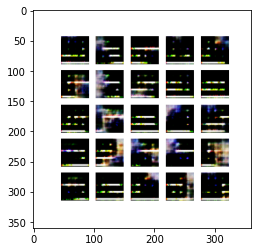

In [ ]:
from skimage.io import imread
a = imread('gan_images/2000.png')
plt.imshow(a)

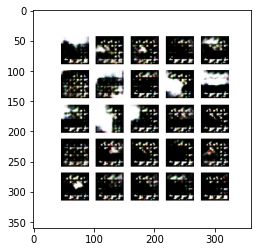

In [ ]:
from skimage.io import imread
a = imread('gan_images/4800.png')
plt.imshow(a)